# Data Wrangling (I + II)

Este notebook unifica, en un flujo único y lineal, los contenidos de:

1. **Data Wrangling I (Apuntes)**
2. **Demostración: Wrangling con Titanic** (revisar personalmente)
3. **Data Wrangling II (Concatenación y Merge)**

> Nota: Los notebooks originales dependían de archivos externos (CSV/XLSX). Para que este notebook sea **ejecutable de punta a punta**, al inicio se incluye una celda que **crea datasets de ejemplo** si los archivos no están disponibles en el directorio de trabajo.


In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

# ---------------------------------------------------------------------
# Setup de datos de ejemplo (solo si no existen archivos en el entorno)
# ---------------------------------------------------------------------

def _ensure_parent(path: Path) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)


def _write_if_missing(path: Path, writer_fn):
    if path.exists():
        return
    _ensure_parent(path)
    writer_fn(path)


# 1) resumen_sueldos.xlsx (para muestreo)

def _make_resumen_sueldos(path: Path):
    rng = np.random.default_rng(42)
    n = 200
    df = pd.DataFrame({
        'Empleado': [f'Empleado_{i:03d}' for i in range(1, n+1)],
        'Área': rng.choice(['TI', 'Finanzas', 'Operaciones', 'RRHH'], size=n),
        'Sueldo': rng.integers(550_000, 2_200_000, size=n),
        'Antigüedad_años': rng.integers(0, 16, size=n)
    })
    df.to_excel(path, index=False)


# 2) flights-dups.csv (para duplicados)

def _make_flights_dups(path: Path):
    df = pd.DataFrame({
        'year': [1949, 1949, 1949, 1951, 1951, 1959, 1959],
        'month': ['June', 'June', 'July', 'December', 'December', 'January', 'January'],
        'passengers': [112, 112, 118, 140, 140, 360, 360]
    })
    # agregamos una fila duplicada completa
    df = pd.concat([df, df.iloc[[0]]], ignore_index=True)
    df.to_csv(path, index=False)


# 3) sueldos.xlsx (para categóricas, ordenamiento, columnas/índices)

def _make_sueldos(path: Path):
    rng = np.random.default_rng(7)
    n = 30
    titulos = ['Ingeniería', 'Administración', 'Salud', 'Educación']
    ubic = ['Santiago', 'Valparaíso', 'Concepción']
    sueldo_base = rng.integers(450_000, 2_800_000, size=n)

    # formato con separador de miles tipo "1.234.567"
    def fmt(x: int) -> str:
        return f"{x:,}".replace(',', '.')

    df = pd.DataFrame({
        '_id': np.arange(1, n+1),
        'NOMBRE': [f'Persona_{i:02d}' for i in range(1, n+1)],
        'SEXO': rng.choice(['M', 'F'], size=n),
        'TITULO Y/O ESPECIALIDAD': rng.choice(titulos, size=n),
        'LUGAR DE SU FUNCION': rng.choice(ubic, size=n),
        'SUELDO LIQUIDO': [fmt(x) for x in sueldo_base]
    })
    df.to_excel(path, index=False)


# 4) titanic.csv (para regex y demostración)

def _make_titanic(path: Path):
    df = pd.DataFrame({
        'PassengerId': [1,2,3,4,5,6],
        'Survived': [0,1,1,1,0,0],
        'Pclass': [3,1,3,1,3,2],
        'Name': [
            'Braund, Mr. Owen Harris',
            'Cumings, Mrs. John Bradley',
            'Heikkinen, Miss. Laina',
            'Futrelle, Mrs. Jacques Heath',
            'Allen, Master. William Henry',
            # uno que rompe el patrón regex (para mostrar el caso)
            '"Test" Name Without Pattern'
        ],
        'Sex': ['male','female','female','female','male','male'],
        'Age': [22.0, 38.0, 26.0, np.nan, 4.0, np.nan],
        'SibSp': [1,1,0,1,3,0],
        'Parch': [0,0,0,0,1,0],
        'Ticket': ['A/5 21171','PC 17599','STON/O2. 3101282','113803','373450','237736'],
        'Fare': [7.25, 71.2833, 7.925, 53.1, 8.05, 13.0],
        'Cabin': [np.nan,'C85',np.nan,'C123',np.nan,np.nan],
        'Embarked': ['S','C','S','S','S','Q']
    })
    df.to_csv(path, index=False)


# 5) real-estate.csv (para limpieza de columnas y conversión de tipos)

def _make_real_estate(path: Path):
    df = pd.DataFrame({
        'ID': [101,102,103,104,105],
        # valores intencionalmente inconsistentes para mostrar limpieza
        'OWN_OCCUPIED': ['Y', 'N', ' ', 'Unknown', 'N'],
        # columna con un valor no numérico para mostrar conversión segura
        'NUM_BATH': ['1', '2', '2.5', 'unknown', '3'],
        'PRICE': [120000, 220000, 180000, 150000, 310000]
    })
    df.to_csv(path, index=False)


# 6) Valor-UF-SII.csv (para concat)

def _make_valor_uf(path: Path):
    # 6 columnas con separador ';' sin header
    rows = [
        ['01', '35000', '11', '35100', '21', '35200'],
        ['02', '35010', '12', '35110', '22', '35210'],
        ['03', '35020', '13', '35120', '', ''],  # valores vacíos para mostrar dropna
        ['04', '35030', '14', '35130', '24', '35230'],
        ['05', '35040', '15', '35140', '25', '35240'],
    ]
    content = "\n".join([";".join(r) for r in rows])
    path.write_text(content, encoding='utf-8')


# 7) riesgo-segmento.xlsx (para merge)

def _make_riesgo_segmento(path: Path):
    clientes = pd.DataFrame({
        'RUT': ['11-1','22-2','33-3','44-4'],
        'NOMBRE': ['Ana','Beto','Carla','Diego'],
        'COD_COMUNA': [101, 102, 101, 103],
        'COD_SEGMENTO': [1, 2, 2, 3]
    })

    comunas = pd.DataFrame({
        'COD_COMUNA': [101,102,103,104],
        'COMUNA': ['Providencia','Ñuñoa','Maipú','La Florida']
    })

    factores = pd.DataFrame({
        'COD_SEGMENTO': [1,2,3],
        'COD_COMUNA': [101,101,103],
        'FACTOR_RIESGO': [0.9, 1.2, 1.1]
    })

    with pd.ExcelWriter(path) as writer:
        clientes.to_excel(writer, sheet_name='Clientes', index=False)
        comunas.to_excel(writer, sheet_name='Comunas', index=False)
        factores.to_excel(writer, sheet_name='Factores Riesgo', index=False)


# Crear archivos si no existen
_write_if_missing(Path('resumen_sueldos.xlsx'), _make_resumen_sueldos)
_write_if_missing(Path('flights-dups.csv'), _make_flights_dups)
_write_if_missing(Path('sueldos.xlsx'), _make_sueldos)
_write_if_missing(Path('titanic.csv'), _make_titanic)
_write_if_missing(Path('real-estate.csv'), _make_real_estate)

# Validación mínima: si el archivo existe pero no contiene las columnas usadas en el ejemplo,
# se regenera un dataset de juguete para que el notebook sea ejecutable.
try:
    _tmp = pd.read_csv('real-estate.csv')
    if not {'OWN_OCCUPIED','NUM_BATH'}.issubset(_tmp.columns):
        _make_real_estate(Path('real-estate.csv'))
except Exception:
    _make_real_estate(Path('real-estate.csv'))
_write_if_missing(Path('Valor-UF-SII.csv'), _make_valor_uf)
_write_if_missing(Path('riesgo-segmento.xlsx'), _make_riesgo_segmento)

print('Datasets listos. Archivos disponibles en el directorio actual:')
for f in ['resumen_sueldos.xlsx','flights-dups.csv','sueldos.xlsx','titanic.csv','real-estate.csv','Valor-UF-SII.csv','riesgo-segmento.xlsx']:
    print(' -', f, 'OK' if Path(f).exists() else 'NO')


Datasets listos. Archivos disponibles en el directorio actual:
 - resumen_sueldos.xlsx OK
 - flights-dups.csv OK
 - sueldos.xlsx OK
 - titanic.csv OK
 - real-estate.csv OK
 - Valor-UF-SII.csv OK
 - riesgo-segmento.xlsx OK


## 1) Data Wrangling I (Apuntes)

En esta sección cubrimos técnicas fundamentales: muestreo, duplicados, chequeo de categóricas, transformaciones, expresiones regulares, conversión de tipos, ordenamiento, y manejo de columnas/índices.


In [1]:
import pandas as pd
import numpy as np

### Muestreos Aleatorios

In [3]:
df = pd.read_excel('resumen_sueldos.xlsx')
df.head(2)

,Empleado,Área,Sueldo,Antigüedad_años
0,Empleado_001,TI,1154334,15
1,Empleado_002,RRHH,2049158,12


In [4]:
df.sample(n=5)

,Empleado,Área,Sueldo,Antigüedad_años
89,Empleado_090,RRHH,1331257,9
144,Empleado_145,RRHH,2044128,13
75,Empleado_076,Finanzas,1345800,12
115,Empleado_116,Operaciones,1638047,1
168,Empleado_169,Finanzas,586488,10


In [5]:
print(df.sample(frac=.05).shape)
df.sample(frac=.05)

(10, 4)


,Empleado,Área,Sueldo,Antigüedad_años
64,Empleado_065,Finanzas,2182978,0
42,Empleado_043,Operaciones,706246,2
0,Empleado_001,TI,1154334,15
52,Empleado_053,Finanzas,860571,7
18,Empleado_019,RRHH,1287589,4
152,Empleado_153,RRHH,1043016,13
187,Empleado_188,Finanzas,1921335,1
162,Empleado_163,Finanzas,918639,7
173,Empleado_174,Operaciones,1166535,0
44,Empleado_045,TI,1587429,8


In [6]:
# Fijar semilla
np.random.seed(2026)
df.sample(frac=.05)

,Empleado,Área,Sueldo,Antigüedad_años
115,Empleado_116,Operaciones,1638047,1
91,Empleado_092,RRHH,990509,13
15,Empleado_016,RRHH,999198,10
57,Empleado_058,TI,720614,10
123,Empleado_124,Finanzas,2061419,13
5,Empleado_006,RRHH,988685,8
193,Empleado_194,Finanzas,1538981,15
196,Empleado_197,Finanzas,623894,9
88,Empleado_089,RRHH,1444703,12
185,Empleado_186,Finanzas,752550,14


### Duplicados

In [2]:
df = pd.read_csv('flights-dups.csv')
df.head(2)

,year,month,passengers
0,1949,June,112
1,1949,June,112


In [4]:
# señalar duplicados
df.duplicated()

0    False
1     True
2    False
3    False
4     True
5    False
6     True
7     True
dtype: bool

In [5]:
# contabilizar duplicados
df.duplicated().sum()

np.int64(4)

In [6]:
# contabilizar duplicados en ciertas columnas
df.duplicated(subset=['year','month']).sum()

np.int64(4)

In [7]:
# contabilizar no duplicados en ciertas columnas
(~df.duplicated(subset=['year','month'])).sum()

np.int64(4)

In [8]:
# contabilizar no duplicados en todo el dataset
(~df.duplicated()).sum()

np.int64(4)

In [9]:
# identificación de las filas duplicados
df[df.duplicated()]

,year,month,passengers
1,1949,June,112
4,1951,December,140
6,1959,January,360
7,1949,June,112


In [10]:
df[(df['year']==1949) & (df['month']=='June')]

,year,month,passengers
0,1949,June,112
1,1949,June,112
7,1949,June,112


In [11]:
df[(df['year']==1951) & (df['month']=='December')]

,year,month,passengers
3,1951,December,140
4,1951,December,140


In [12]:
df[(df['year']==1959) & (df['month']=='January')]

,year,month,passengers
5,1959,January,360
6,1959,January,360


In [13]:
df.shape

(8, 3)

In [14]:
# eliminación de duplicados
df.drop_duplicates()

,year,month,passengers
0,1949,June,112
2,1949,July,118
3,1951,December,140
5,1959,January,360


In [15]:
df.shape

(8, 3)

### Chequeo de columnas categóricas

In [16]:
df = pd.read_excel('sueldos.xlsx')

In [17]:
df.head(2)

,_id,NOMBRE,SEXO,TITULO Y/O ESPECIALIDAD,LUGAR DE SU FUNCION,SUELDO LIQUIDO
0,1,Persona_01,F,Administración,Santiago,2.670.526
1,2,Persona_02,F,Administración,Concepción,1.918.974


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   _id                      30 non-null     int64 
 1   NOMBRE                   30 non-null     object
 2   SEXO                     30 non-null     object
 3   TITULO Y/O ESPECIALIDAD  30 non-null     object
 4   LUGAR DE SU FUNCION      30 non-null     object
 5   SUELDO LIQUIDO           30 non-null     object
dtypes: int64(1), object(5)
memory usage: 1.5+ KB


In [19]:
# valores únicos de una serie
df['TITULO Y/O ESPECIALIDAD'].unique()

array(['Administración', 'Ingeniería', 'Educación', 'Salud'], dtype=object)

In [20]:
# cantidad de valores únicos
df['TITULO Y/O ESPECIALIDAD'].nunique()

4

In [21]:
# contabilizar cuántos elementos de cada categoría
df['TITULO Y/O ESPECIALIDAD'].value_counts()

TITULO Y/O ESPECIALIDAD
Ingeniería        8
Educación         8
Salud             8
Administración    6
Name: count, dtype: int64

In [22]:
df.tail()

,_id,NOMBRE,SEXO,TITULO Y/O ESPECIALIDAD,LUGAR DE SU FUNCION,SUELDO LIQUIDO
25,26,Persona_26,F,Salud,Valparaíso,1.048.943
26,27,Persona_27,F,Educación,Valparaíso,2.777.580
27,28,Persona_28,F,Educación,Concepción,1.495.929
28,29,Persona_29,M,Salud,Valparaíso,1.573.649
29,30,Persona_30,F,Salud,Valparaíso,1.635.688


### Transformación de datos

In [23]:
# Sea la siguiente serie de datos
serie = pd.Series(range(10,20,2))
serie

0    10
1    12
2    14
3    16
4    18
dtype: int64

In [24]:
# sea la siguiente función
def cubo(x):
    return x**3

In [25]:
# forma tradicional de transformar una serie
out = pd.Series(dtype=int)
for i,e in serie.items():
    out.at[i] = cubo(e)
print(out)

0    1000
1    1728
2    2744
3    4096
4    5832
dtype: int64


In [26]:
# aplicamos la función cubo a cada uno de los elementos
# de la serie
serie.apply(cubo)

0    1000
1    1728
2    2744
3    4096
4    5832
dtype: int64

In [27]:
# utilizando expresiones lambda
serie.apply(lambda x : x**3)

0    1000
1    1728
2    2744
3    4096
4    5832
dtype: int64

In [28]:
# limpienza de columnas
df = pd.read_csv('real-estate.csv')
df['OWN_OCCUPIED']

0          Y
1          N
2           
3    Unknown
4          N
Name: OWN_OCCUPIED, dtype: object

In [29]:
df['OWN_OCCUPIED'].unique()

array(['Y', 'N', ' ', 'Unknown'], dtype=object)

In [30]:
# limpieza de la serie de datos
def limpiar(valor):
    if valor == 'N':
        return valor
    else:
        return 'Y'

In [31]:
df['OWN_OCCUPIED'] = df['OWN_OCCUPIED'].apply(limpiar)

In [32]:
df['OWN_OCCUPIED']

0    Y
1    N
2    Y
3    Y
4    N
Name: OWN_OCCUPIED, dtype: object

In [33]:
# lo mismo en una sola linea
df['OWN_OCCUPIED'].apply(lambda x : x if x=='N' else 'Y')

0    Y
1    N
2    Y
3    Y
4    N
Name: OWN_OCCUPIED, dtype: object

In [34]:
# transformando un dataframe
df = pd.read_csv('titanic.csv')
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley",female,38.0,1,0,PC 17599,71.2833,C85,C


In [35]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            2
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          4
Embarked       0
dtype: int64

In [36]:
# imputación estratificada
df[['Age','Pclass']].groupby('Pclass').mean()

,Age
Pclass,
1,38.000000
2,NaN
3,17.333333


In [37]:
def imputar_edad(pclass, age):
    # si la edad es nula, realizamos la imputacion
    if pd.isnull(age):
        if pclass == 1:
            return 38.23
        elif pclass == 2:
            return 29.67
        elif pclass == 3:
            return 25.14
    else:
    # caso contrario, retornamos el mismo valor
        return age

In [38]:
# algunas pruebas
print(imputar_edad(1, np.nan))
print(imputar_edad(2, np.nan))
print(imputar_edad(3, np.nan))
print(imputar_edad(1, 35))

38.23
29.67
25.14
35


In [39]:
# aplicamos la función
df['Age']=df[['Age','Pclass']].apply(lambda row : imputar_edad(row['Pclass'],row['Age']), axis=1)

In [40]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          4
Embarked       0
dtype: int64

### Expresiones regulares

In [41]:
df = pd.read_csv('titanic.csv')
df['Name'][:10]

0         Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley
2          Heikkinen, Miss. Laina
3    Futrelle, Mrs. Jacques Heath
4    Allen, Master. William Henry
5     "Test" Name Without Pattern
Name: Name, dtype: object

In [42]:
import re

In [43]:
# creamos una expresión regular
p = re.compile('^([A-Za-z]*), (([A-Za-z]*))\. (([A-Za-z]*)) .*$')

<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_7202/213356142.py:2: SyntaxWarning: invalid escape sequence '\.'
  p = re.compile('^([A-Za-z]*), (([A-Za-z]*))\. (([A-Za-z]*)) .*$')


In [44]:
# hacemos una prueba
s = 'Braund, Mr. Owen Harris'
print(bool(p.match(s)))

True


In [45]:
# ahora verificamos si la columna cumple el patrón
df['Name'].apply(lambda x : bool(p.match(x)))

0     True
1     True
2    False
3     True
4     True
5    False
Name: Name, dtype: bool

In [46]:
df[~df['Name'].apply(lambda x : bool(p.match(x)))]['Name']

2         Heikkinen, Miss. Laina
5    "Test" Name Without Pattern
Name: Name, dtype: object

### Conversión de tipos de dato

In [47]:
df = pd.read_csv('real-estate.csv')
df

,ID,OWN_OCCUPIED,NUM_BATH,PRICE
0,101,Y,1,120000
1,102,N,2,220000
2,103,,2.5,180000
3,104,Unknown,unknown,150000
4,105,N,3,310000


In [48]:
# sabemos que se va a caer (porque hay valores no numéricos)
try:
    df['NUM_BATH'].astype(float)
except ValueError as e:
    print('Error esperado:', e)


Error esperado: could not convert string to float: 'unknown'


In [49]:
# tiene una cadena de caracteres en entre medio
df['NUM_BATH'].astype(float, errors='ignore')

0          1
1          2
2        2.5
3    unknown
4          3
Name: NUM_BATH, dtype: object

In [50]:
# otra técnica de conversión
def convertir(valor):
    try:
        return float(valor)
    except:
        return np.nan

In [55]:
df['NUM_BATH'].apply(convertir)

0    1.0
1    2.0
2    2.5
3    NaN
4    3.0
Name: NUM_BATH, dtype: float64

### Ordenamiento

In [51]:
df = pd.read_excel('sueldos.xlsx')
df.head(2)

,_id,NOMBRE,SEXO,TITULO Y/O ESPECIALIDAD,LUGAR DE SU FUNCION,SUELDO LIQUIDO
0,1,Persona_01,F,Administración,Santiago,2.670.526
1,2,Persona_02,F,Administración,Concepción,1.918.974


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   _id                      30 non-null     int64 
 1   NOMBRE                   30 non-null     object
 2   SEXO                     30 non-null     object
 3   TITULO Y/O ESPECIALIDAD  30 non-null     object
 4   LUGAR DE SU FUNCION      30 non-null     object
 5   SUELDO LIQUIDO           30 non-null     object
dtypes: int64(1), object(5)
memory usage: 1.5+ KB


In [58]:
df['SUELDO LIQUIDO'] = df['SUELDO LIQUIDO'].apply(lambda x : x.replace('.',''))
df['SUELDO LIQUIDO'] = df['SUELDO LIQUIDO'].astype(int)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   _id                      30 non-null     int64 
 1   NOMBRE                   30 non-null     object
 2   SEXO                     30 non-null     object
 3   TITULO Y/O ESPECIALIDAD  30 non-null     object
 4   LUGAR DE SU FUNCION      30 non-null     object
 5   SUELDO LIQUIDO           30 non-null     int64 
dtypes: int64(2), object(4)
memory usage: 1.5+ KB


In [60]:
df.sort_values(by='SUELDO LIQUIDO', ascending=False).head()

,_id,NOMBRE,SEXO,TITULO Y/O ESPECIALIDAD,LUGAR DE SU FUNCION,SUELDO LIQUIDO
26,27,Persona_27,F,Educación,Valparaíso,2777580
0,1,Persona_01,F,Administración,Santiago,2670526
12,13,Persona_13,F,Salud,Valparaíso,2594664
3,4,Persona_04,F,Ingeniería,Santiago,2558452
11,12,Persona_12,M,Ingeniería,Valparaíso,2502850


### Columnas e índices

In [61]:
df = pd.read_excel('sueldos.xlsx')
df.head(2)

,_id,NOMBRE,SEXO,TITULO Y/O ESPECIALIDAD,LUGAR DE SU FUNCION,SUELDO LIQUIDO
0,1,Persona_01,F,Administración,Santiago,2.670.526
1,2,Persona_02,F,Administración,Concepción,1.918.974


In [62]:
# renombrar columnas
df.rename(columns={'_id':'PID', 'LUGAR DE SU FUNCION':'UBICACION'}, inplace=True)

In [63]:
# entrega listado de columnas del df
df.columns

Index(['PID', 'NOMBRE', 'SEXO', 'TITULO Y/O ESPECIALIDAD', 'UBICACION',
       'SUELDO LIQUIDO'],
      dtype='object')

In [64]:
# setear un índice
df.set_index('PID', inplace=True)
df.head()

,NOMBRE,SEXO,TITULO Y/O ESPECIALIDAD,UBICACION,SUELDO LIQUIDO
PID,,,,,
1,Persona_01,F,Administración,Santiago,2.670.526
2,Persona_02,F,Administración,Concepción,1.918.974
3,Persona_03,F,Administración,Valparaíso,2.057.822
4,Persona_04,F,Ingeniería,Santiago,2.558.452
5,Persona_05,F,Educación,Santiago,1.808.987


In [65]:
# resetear el índice
df.reset_index(inplace=True)
df.head()

,PID,NOMBRE,SEXO,TITULO Y/O ESPECIALIDAD,UBICACION,SUELDO LIQUIDO
0,1,Persona_01,F,Administración,Santiago,2.670.526
1,2,Persona_02,F,Administración,Concepción,1.918.974
2,3,Persona_03,F,Administración,Valparaíso,2.057.822
3,4,Persona_04,F,Ingeniería,Santiago,2.558.452
4,5,Persona_05,F,Educación,Santiago,1.808.987


In [66]:
# eliminación de una columna
df.drop('UBICACION',axis=1).head()

,PID,NOMBRE,SEXO,TITULO Y/O ESPECIALIDAD,SUELDO LIQUIDO
0,1,Persona_01,F,Administración,2.670.526
1,2,Persona_02,F,Administración,1.918.974
2,3,Persona_03,F,Administración,2.057.822
3,4,Persona_04,F,Ingeniería,2.558.452
4,5,Persona_05,F,Educación,1.808.987


In [67]:
# eliminación de varias columnas
df.drop(['UBICACION','TITULO Y/O ESPECIALIDAD'],axis=1).head()

,PID,NOMBRE,SEXO,SUELDO LIQUIDO
0,1,Persona_01,F,2.670.526
1,2,Persona_02,F,1.918.974
2,3,Persona_03,F,2.057.822
3,4,Persona_04,F,2.558.452
4,5,Persona_05,F,1.808.987


---

## 2) Data Wrangling II (Concatenación y Merge)

En esta sección avanzamos a operaciones de integración de datos:

- **Concatenación** (apilar datasets homogéneos).
- **Merge/Join** (combinar datasets por llaves).


In [68]:
import pandas as pd

### Concatenación de dataframes

In [69]:
df = pd.read_csv('Valor-UF-SII.csv')
df.head()

,01;35000;11;35100;21;35200
0,02;35010;12;35110;22;35210
1,03;35020;13;35120;;
2,04;35030;14;35130;24;35230
3,05;35040;15;35140;25;35240


In [70]:
# Lectura con separador, sin header y asignación de nombres de columnas
df = pd.read_csv('Valor-UF-SII.csv', sep=';', header=None,
            names=['dia.1', 'valor.1', 'dia.2', 'valor.2', 'dia.3', 'valor.3'])
df.head()

,dia.1,valor.1,dia.2,valor.2,dia.3,valor.3
0,1,35000,11,35100,21.0,35200.0
1,2,35010,12,35110,22.0,35210.0
2,3,35020,13,35120,NaN,NaN
3,4,35030,14,35130,24.0,35230.0
4,5,35040,15,35140,25.0,35240.0


In [71]:
# creación de 3 nuevos dataframes
# seleccionando las respecticas columnas
df1 = df.iloc[:,:2].copy()
df2 = df.iloc[:,2:4].copy()
df3 = df.iloc[:,4:].copy()

In [72]:
df1.head(2)

,dia.1,valor.1
0,1,35000
1,2,35010


In [73]:
df2.head(2)

,dia.2,valor.2
0,11,35100
1,12,35110


In [74]:
df3.head(2)

,dia.3,valor.3
0,21.0,35200.0
1,22.0,35210.0


In [75]:
#renombramiento de columnas
df1.rename(columns={'dia.1':'Dia', 'valor.1':'Valor'}, inplace=True)
df2.rename(columns={'dia.2':'Dia', 'valor.2':'Valor'}, inplace=True)
df3.rename(columns={'dia.3':'Dia', 'valor.3':'Valor'}, inplace=True)

In [76]:
df1.head(2)

,Dia,Valor
0,1,35000
1,2,35010


In [77]:
# Concatenación de los 3 dataframes anteriores
dft = pd.concat([df1,df2,df3])
dft

,Dia,Valor
0,1.0,35000.0
1,2.0,35010.0
2,3.0,35020.0
3,4.0,35030.0
4,5.0,35040.0
0,11.0,35100.0
1,12.0,35110.0
2,13.0,35120.0
3,14.0,35130.0
4,15.0,35140.0


In [78]:
# eliminamos valores nulos
dft.dropna(inplace=True)

# reseteamos el indice
dft.reset_index(inplace=True, drop=True)

In [79]:
dft

,Dia,Valor
0,1.0,35000.0
1,2.0,35010.0
2,3.0,35020.0
3,4.0,35030.0
4,5.0,35040.0
5,11.0,35100.0
6,12.0,35110.0
7,13.0,35120.0
8,14.0,35130.0
9,15.0,35140.0


### Merge de dataframes



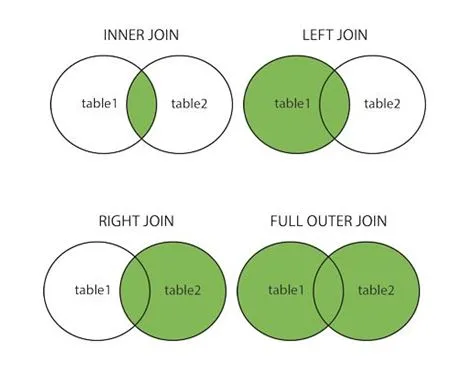

In [80]:
df1 = pd.read_excel('riesgo-segmento.xlsx', sheet_name='Clientes')
df1

,RUT,NOMBRE,COD_COMUNA,COD_SEGMENTO
0,11-1,Ana,101,1
1,22-2,Beto,102,2
2,33-3,Carla,101,2
3,44-4,Diego,103,3


In [81]:
df2 = pd.read_excel('riesgo-segmento.xlsx',
                                  sheet_name='Comunas')
df2

,COD_COMUNA,COMUNA
0,101,Providencia
1,102,Ñuñoa
2,103,Maipú
3,104,La Florida


In [82]:
df3 = pd.read_excel('riesgo-segmento.xlsx',
                       sheet_name='Factores Riesgo')
df3

,COD_SEGMENTO,COD_COMUNA,FACTOR_RIESGO
0,1,101,0.9
1,2,101,1.2
2,3,103,1.1


In [83]:
# merge clientes comuna
pd.merge(df1,df2, how='inner', on='COD_COMUNA')

,RUT,NOMBRE,COD_COMUNA,COD_SEGMENTO,COMUNA
0,11-1,Ana,101,1,Providencia
1,22-2,Beto,102,2,Ñuñoa
2,33-3,Carla,101,2,Providencia
3,44-4,Diego,103,3,Maipú


In [84]:
# merge clientes comuna método inner
pd.merge(df1,df2, how='inner', on='COD_COMUNA')

,RUT,NOMBRE,COD_COMUNA,COD_SEGMENTO,COMUNA
0,11-1,Ana,101,1,Providencia
1,22-2,Beto,102,2,Ñuñoa
2,33-3,Carla,101,2,Providencia
3,44-4,Diego,103,3,Maipú


In [85]:
# left merge
pd.merge(df1,df2, how='left', on='COD_COMUNA')

,RUT,NOMBRE,COD_COMUNA,COD_SEGMENTO,COMUNA
0,11-1,Ana,101,1,Providencia
1,22-2,Beto,102,2,Ñuñoa
2,33-3,Carla,101,2,Providencia
3,44-4,Diego,103,3,Maipú


In [86]:
# rigth merge
pd.merge(df1,df2, how='right', on='COD_COMUNA')

,RUT,NOMBRE,COD_COMUNA,COD_SEGMENTO,COMUNA
0,11-1,Ana,101,1.0,Providencia
1,33-3,Carla,101,2.0,Providencia
2,22-2,Beto,102,2.0,Ñuñoa
3,44-4,Diego,103,3.0,Maipú
4,NaN,NaN,104,NaN,La Florida


In [87]:
# outer merge
pd.merge(df1,df2, how='outer', on='COD_COMUNA')

,RUT,NOMBRE,COD_COMUNA,COD_SEGMENTO,COMUNA
0,11-1,Ana,101,1.0,Providencia
1,33-3,Carla,101,2.0,Providencia
2,22-2,Beto,102,2.0,Ñuñoa
3,44-4,Diego,103,3.0,Maipú
4,NaN,NaN,104,NaN,La Florida


In [88]:
pd.merge(df1,df3, how='left', on=['COD_SEGMENTO','COD_COMUNA'])

,RUT,NOMBRE,COD_COMUNA,COD_SEGMENTO,FACTOR_RIESGO
0,11-1,Ana,101,1,0.9
1,22-2,Beto,102,2,NaN
2,33-3,Carla,101,2,1.2
3,44-4,Diego,103,3,1.1
